In [1]:
%load_ext autoreload
%autoreload 2
import os
import numpy as np
import pandas as pd

import tensorflow as tf
from micron2.clustering import Autoencoder, train_AE_simCLR
from micron2.data import stream_dataset

import tqdm.auto as tqdm

In [2]:
import h5py
f = h5py.File('/dev/shm/dataset.hdf5', 'r')
print(f['meta/channel_names'][:])
use_channels = [b.decode('UTF-8') for b in f['meta/channel_names'][:]]
# fn = lambda x,y: print(x)
print(f.keys())
print(f['cells'].keys())
f.close()

[b'DAPI' b'OX40L' b'CD45' b'CD20' b'CD134' b'CD68' b'CD31' b'CD103'
 b'HLA-DR' b'CXCR5' b'IgG' b'CD3e' b'Ki-67' b'LAG3' b'CXCL13' b'IgA'
 b'CD89' b'PNaD' b'PD-L1' b'PD-1' b'CD11c' b'CD80' b'CD69' b'TIM3'
 b'CD45RO' b'CD40LG' b'FOXP3' b'CD64' b'GZMB' b'C1q' b'CD40' b'CD45RA'
 b'CD138' b'IL7R' b'IgM' b'PDGFRb' b'aSMA' b'CD8' b'CD4' b'PanCytoK']
<KeysViewHDF5 ['cells', 'intensity', 'meta']>
<KeysViewHDF5 ['C1q', 'CD103', 'CD11c', 'CD134', 'CD138', 'CD20', 'CD31', 'CD3e', 'CD4', 'CD40', 'CD40LG', 'CD45', 'CD45RA', 'CD45RO', 'CD64', 'CD68', 'CD69', 'CD8', 'CD80', 'CD89', 'CXCL13', 'CXCR5', 'DAPI', 'FOXP3', 'GZMB', 'HLA-DR', 'IL7R', 'IgA', 'IgG', 'IgM', 'Ki-67', 'LAG3', 'OX40L', 'PD-1', 'PD-L1', 'PDGFRb', 'PNaD', 'PanCytoK', 'TIM3', 'aSMA']>


In [3]:
print(use_channels)
def process(x):
    x = tf.cast(x, tf.float32)/255.
    # x = tf.log1p(x)
    # mn = tf.math.reduce_mean(x, axis=[0,1,2])
    # sd = tf.math.reduce_std(x, axis=[0,1,2])
    x = tf.transpose(tf.image.per_image_standardization(tf.transpose(x)))
    return x
    
dataset = stream_dataset('/dev/shm/dataset.hdf5', use_channels=use_channels)
dataset = (dataset.repeat(15)
           .shuffle(1024 * 6)
           .map(process)
           .batch(16)
           .prefetch(8)
           #.apply(tf.data.experimental.prefetch_to_device("/gpu:0"))
          )

for sample_x in dataset:
    break
    
print(sample_x.shape)
for k in range(sample_x.shape[-1]):
    print(use_channels[k], sample_x.numpy()[...,k].sum())

['DAPI', 'OX40L', 'CD45', 'CD20', 'CD134', 'CD68', 'CD31', 'CD103', 'HLA-DR', 'CXCR5', 'IgG', 'CD3e', 'Ki-67', 'LAG3', 'CXCL13', 'IgA', 'CD89', 'PNaD', 'PD-L1', 'PD-1', 'CD11c', 'CD80', 'CD69', 'TIM3', 'CD45RO', 'CD40LG', 'FOXP3', 'CD64', 'GZMB', 'C1q', 'CD40', 'CD45RA', 'CD138', 'IL7R', 'IgM', 'PDGFRb', 'aSMA', 'CD8', 'CD4', 'PanCytoK']
(16, 64, 64, 40)
DAPI 246318.34
OX40L -12546.296
CD45 15788.588
CD20 -9739.586
CD134 -12546.296
CD68 4686.189
CD31 -12151.827
CD103 -12125.381
HLA-DR -4442.619
CXCR5 -12546.296
IgG 70071.24
CD3e -0.52319336
Ki-67 -11774.518
LAG3 -12546.296
CXCL13 -12221.773
IgA -11013.234
CD89 -12535.062
PNaD -2339.2812
PD-L1 -12546.296
PD-1 -12281.517
CD11c -10213.885
CD80 -11282.96
CD69 -12546.296
TIM3 -7454.4414
CD45RO -12546.296
CD40LG 6915.6943
FOXP3 -12309.929
CD64 -12546.296
GZMB -12546.296
C1q -3467.4065
CD40 -12546.296
CD45RA -12043.735
CD138 -12546.296
IL7R -12546.296
IgM -12546.296
PDGFRb -12546.296
aSMA -10912.636
CD8 -5188.88
CD4 6128.398
PanCytoK -761.343

In [4]:
sample_x = tf.image.random_crop(sample_x, size=(sample_x.shape[0], 48, 48, sample_x.shape[-1]))
ae_model = Autoencoder(input_shape=sample_x.shape[1:])
y, z_g = ae_model(sample_x, return_g=True)
print(y.shape)
print(z_g.shape)
z = ae_model.encode(sample_x)
print(z.shape)

/home/ing/miniconda3/envs/micron2/lib/python3.8/site-packages/tensorflow/python/keras/applications/imagenet_utils.py:331: UserWarning: This model usually expects 1 or 3 input channels. However, it was passed an input_shape with 40 input channels.
  warnings.warn('This model usually expects 1 or 3 input channels. '


(16, 48, 48, 40)
(16, 32)
(16, 256)


In [5]:
ae_model.summary()

Model: "autoencoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50v2 (Functional)      (None, 2, 2, 2048)        23680832  
_________________________________________________________________
conv2d (Conv2D)              multiple                  2097408   
_________________________________________________________________
g_simclr (Dense)             multiple                  8224      
_________________________________________________________________
conv2d_transpose (Conv2DTran multiple                  2097408   
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr multiple                  295040    
_________________________________________________________________
conv2d_transpose_2 (Conv2DTr multiple                  204864    
_________________________________________________________________
conv2d_transpose_3 (Conv2DTr multiple                  

In [7]:
outdir = 'trained_simclr'
ae_model.load_weights('trained_simclr/weights.h5')

In [8]:
train_AE_simCLR(dataset, ae_model)

In [9]:
ae_model.save_weights(f'{outdir}/weights.h5')

In [12]:
!ls -lha trained_simclr

total 275M
drwxrwxr-x 2 ing ing 4.0K Nov 16 22:32 .
drwxrwxr-x 4 ing ing 4.0K Nov 17 09:08 ..
-rw-rw-r-- 1 ing ing 114M Nov 17 05:22 weights.h5
-rw-rw-r-- 1 ing ing 144M Nov 16 22:32 z_L2.npy
-rw-rw-r-- 1 ing ing  18M Nov 16 22:32 z.npy


channel 0	DAPI      	pred 149056.11	real 142616.11
channel 1	OX40L     	pred 0.00	real -7057.29
channel 2	CD45      	pred 13954.71	real 8886.11
channel 3	CD20      	pred 0.00	real -5591.14
channel 4	CD134     	pred 0.00	real -7057.29
channel 5	CD68      	pred 8858.28	real 4531.63
channel 6	CD31      	pred 0.00	real -6802.00
channel 7	CD103     	pred 0.00	real -7008.12
channel 8	HLA-DR    	pred 3722.63	real -2091.21
channel 9	CXCR5     	pred 0.00	real -7057.29
channel 10	IgG       	pred 37806.95	real 33544.11
channel 11	CD3e      	pred 6504.98	real 261.79
channel 12	Ki-67     	pred 0.00	real -6377.67
channel 13	LAG3      	pred 0.02	real -7057.29
channel 14	CXCL13    	pred 0.00	real -6967.08
channel 15	IgA       	pred 0.00	real -6528.39
channel 16	CD89      	pred 0.00	real -7054.47
channel 17	PNaD      	pred 0.00	real -368.33
channel 18	PD-L1     	pred 0.00	real -7057.29
channel 19	PD-1      	pred 0.00	real -7038.42
channel 20	CD11c     	pred 0.00	real -5470.92
channel 21	CD80      	pred

<Figure size 432x288 with 0 Axes>

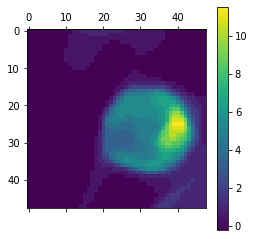

<Figure size 432x288 with 0 Axes>

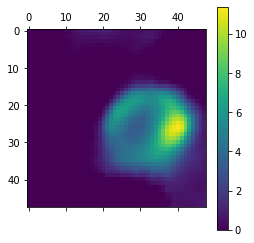

In [20]:
from matplotlib import pyplot as plt
sample_xout = ae_model(sample_x)
for j in range(sample_x.shape[-1]):
    print(f'channel {j}\t' +\
          f'{use_channels[j]:<10}\t'
          f'pred {tf.reduce_sum(sample_xout[...,j]).numpy():<4.2f}\t' +\
          f'real {tf.reduce_sum(sample_x[...,j]).numpy():<4.2f}')

idx = np.random.choice(sample_xout.shape[0])
jdx = np.random.choice(sample_xout.shape[-1])

jdx = 10 

print(idx, jdx)
sx = sample_x.numpy()[idx, :,:, jdx]
sxout = sample_xout.numpy()[idx, :,:, jdx] 
print(jdx, sx.sum(), sxout.sum())

plt.figure()
plt.matshow(sx)# / sx.max())
plt.colorbar()

plt.figure()
plt.matshow(sxout)# / sxout.max())
plt.colorbar()